In [0]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/Team Drives/Deep Learning/FinalProject/'
myDrive = '/content/drive/Team Drives/Deep Learning/FinalProject/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'Còpia de FinalProject.ipynb'	     FinalProject.ipynb
'Còpia de FinalProjectJORDI.ipynb'   image_49.png
 data				     models
'Face emotion recognition.gdoc'     'Presentació sense títol.gslides'
'Face emotion recognition.pdf'	     Source.gdoc


In [0]:
#Libraries needed to run this file.
import matplotlib.pyplot as plt

import numpy as np
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torchvision.utils import save_image
from torch.nn import functional as F
import torch.optim as optim
import os
from PIL import Image

In [0]:
#Creates a list that contains the possible labels for the images (both train and test).
labelList = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
#Defines cuda device for running this file if it is available.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Loads data from our dataset. Can be used for train and test loaders.
class emotionLoader(torch.utils.data.Dataset):
    #Loads all the images and its corresponding label.
    def __init__(self,dataDir = './data/train/',transform = None):
        #Initialize the data and label list
        self.labels = []
        self.data = []
        
        #List all the images of the given folder and sort them.
        listImage = os.listdir(dataDir)
        listImage = sorted(listImage)
        
        #For loop through the label list.
        for i in range( len(labelList) ):
            print(labelList[i])
            #Creates the path of each folder (angry, sad, neutral, ...).
            path = dataDir + labelList[i] + '/'
            #List the images inside the current folder.
            listImage = os.listdir(path)

            #For loop through the images of a folder.
            for face in listImage:
                #Read the data using PIL and appends it to data list.
                self.data.append(Image.open(path+face))
                #Also appends the label of the current image.
                self.labels.append(torch.FloatTensor([i]))
        
        self.transform = transform
        
    #Given and index, returns the image and label located at this index.
    def __getitem__(self, index):
        #Gets the image and the label located at the given index.
        data = self.data[index]
        lbl = self.labels[index]
        
        #If there are some transformations apply them to the image.
        if self.transform is not None : 
            data = self.transform(data)
        
        #Return both image and label.
        return data,lbl
    
    #Returns the size of data loaded.
    def __len__(self):
        return len(self.data)


In [0]:
#Our network.
class Net(nn.Module):
    
    #Define all the layers involved and the number of classes.
    def __init__(self, num_classes=7):
        super(Net, self).__init__()     
        #As label list has length 7, our network will have 7 classes.
        self.classes = num_classes
        #First liner layer. In features = 64*23*23 and out features = 64.
        self.in1 = nn.Linear(64*23*23, 64)
        #Second linear layer. In features = out features linear layer 1 and out layer = number of clases.
        self.in2 = nn.Linear(64, 7)
        #First conv. layer. In channels = 1, out channels = 32 and kernel size of 3x3.
        self.l1 = nn.Conv2d(1, 32, 3)
        #Second conv.layer. In channel = out channels conv. layer 1, out channels = 64 and kernel size of 1x1.
        self.l2 = nn.Conv2d(32, 64, 1)      
        
        #Relu activation function.
        self.relu =  nn.ReLU(True)
        #Max pooling with kernel size of 2x2.
        self.pool = nn.MaxPool2d(2)
        #Dropout with probability of an element to be zeroed equals to 0.25.
        self.drop = nn.Dropout(0.25)
        #Batch normalization with  64 in features.
        self.batchNorm = nn.BatchNorm2d(64)

    #Forward function.
    def forward(self, x):
        #Returns the result of passing the image x through the first convolutional layer.
        out = self.l1(x)
        #Apply relu activation function to the previous result.
        out = self.relu(out)
        #After that, pass the above result through the second convolutional layer.
        out = self.l2(out)
        #Again, apply relu activation function to that result.
        out = self.relu(out)
        #Apply batch normalization, max pooling and dropout.
        out = self.batchNorm(out)
        out = self.pool(out)
        out = self.drop(out)
        #Reshape the result in order to remove one dimension of it.
        out = out.reshape(out.size(0), -1)
        #Finally, pass the result value through first linear layer and then through second linear layer.
        out = self.in1(out)
        out = self.in2(out)

        #Return the result.
        return out

In [0]:
#Transformation that will be applied to each image.
tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([.5], [.5])
        ])

#Defines the batch size used in both train and test loaders.
batch_size = 64

#Defines train loader.
train = emotionLoader(myDrive + 'data/train/', tr)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                               batch_size=batch_size, 
                                               shuffle=True)
#Defines test loader.
test = emotionLoader(myDrive + 'data/test/', tr)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                               batch_size=batch_size, 
                                               shuffle=True)

angry
disgusted
fearful
happy
neutral
sad
surprised
angry
disgusted
fearful
happy
neutral
sad
surprised


In [0]:
#The training will have 50 epochs.
num_epochs = 50

#Defines the neural network we will use and loads a model.
CNN = Net()
CNN.load_state_dict(torch.load(myDrive + 'models/VGG_Face_torch.pth'), strict=False)
CNN = CNN.cuda()

#Defines the learning rate, the criterion and the optimizer.
learning_rate = .01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

#Train the model.
if True :
    
    print('training')
    total_step = len(train_loader)
    
    #For loop for epochs.
    for epoch in range(num_epochs):
        #For loop through train loader.
        for i, (images, labels) in enumerate(train_loader):
            
            #The images and labels are send to cuda.
            images = images.to(device)
            labels = labels.to(device)
            
            #Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 16 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

training


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Step [16/37], Loss: 135.5347
Epoch [1/50], Step [32/37], Loss: 26.9488


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([41, 1])) that is different to the input size (torch.Size([41, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Step [16/37], Loss: 8.4128
Epoch [2/50], Step [32/37], Loss: 5.8300
Epoch [3/50], Step [16/37], Loss: 5.9808
Epoch [3/50], Step [32/37], Loss: 5.3439
Epoch [4/50], Step [16/37], Loss: 4.7551
Epoch [4/50], Step [32/37], Loss: 5.2715
Epoch [5/50], Step [16/37], Loss: 4.9437
Epoch [5/50], Step [32/37], Loss: 5.5526
Epoch [6/50], Step [16/37], Loss: 4.3204
Epoch [6/50], Step [32/37], Loss: 4.5178
Epoch [7/50], Step [16/37], Loss: 4.7856
Epoch [7/50], Step [32/37], Loss: 4.0562
Epoch [8/50], Step [16/37], Loss: 4.0817
Epoch [8/50], Step [32/37], Loss: 3.2570
Epoch [9/50], Step [16/37], Loss: 3.9865
Epoch [9/50], Step [32/37], Loss: 5.0293
Epoch [10/50], Step [16/37], Loss: 4.5078
Epoch [10/50], Step [32/37], Loss: 3.5477
Epoch [11/50], Step [16/37], Loss: 3.6817
Epoch [11/50], Step [32/37], Loss: 3.1213
Epoch [12/50], Step [16/37], Loss: 3.4172
Epoch [12/50], Step [32/37], Loss: 3.8474
Epoch [13/50], Step [16/37], Loss: 3.5885
Epoch [13/50], Step [32/37], Loss: 3.9218
Epoch [1

Predicted label =  4
Real label =  4
Test Accuracy of the model on the test images: 18.142857142857142 %


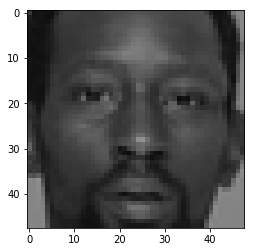

In [0]:
#Modifies the image size as it is modified by the neural network.
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 48, 48)
    return x

#Test the model.
if True :
    
    #Eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance).
    CNN.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        
        #For loop through test loader.
        for i, (images, labels) in enumerate(test_loader):
            #Send both images and labels to cuda in order to perform faster this operations.
            images = images.to(device)
            labels = labels.to(device)
            
            #Return the result of passing the images through the neural network.
            outputs = CNN(images)
            
            #Computes values related to accuracy.
            total += labels.size(0)
            for line in outputs:
                index = (line == torch.max(line)).nonzero()
                correct += (index == int(labels[i].item())).sum().item()
            
            #Shows an example of our model.
            if i%60 == 0:
                pic = to_img(images[i].cpu().data)
                imgName = myDrive+'image_{}.png'.format(epoch)
                save_image(pic, imgName)
                plt.imshow(Image.open(imgName))
                print('Predicted label = ', index.item())
                print('Real label = ', int(labels[i].item()))
            
        print('Test Accuracy of the model on the test images: {} %'.format(100 * (correct / total) ) )